<a href="https://colab.research.google.com/github/manavkdubey/fashion-mnist/blob/main/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST
### This is a python notebook to detect fashion clothings from their image
### We will use classification to categorize the different images we recive and towards the end export out our model to use it to identify custom images

In [31]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import gzip

In [2]:
tf.__version__

'2.13.0'

In [3]:

def load_mnist(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')

        # Read the image data
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(num_images, num_rows, num_cols)

    return data

In [45]:
tempx= load_mnist("/content/drive/MyDrive/data/fashion/train-images-idx3-ubyte")

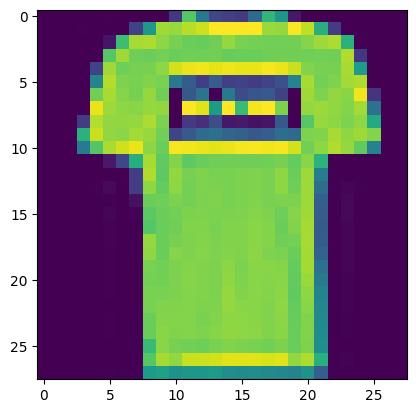

In [46]:
plt.imshow(tempx[1])

In [47]:
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_labels = int.from_bytes(f.read(4), byteorder='big')

        # Read the label data
        label_data = np.fromfile(f, dtype=np.uint8)

    return label_data

In [48]:
y=load_mnist_labels("/content/drive/MyDrive/data/fashion/train-labels-idx1-ubyte")

In [49]:
y

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [50]:
np.argmax(y[1])

0

In [51]:
x_test=load_mnist("/content/drive/MyDrive/data/fashion/t10k-images-idx3-ubyte")

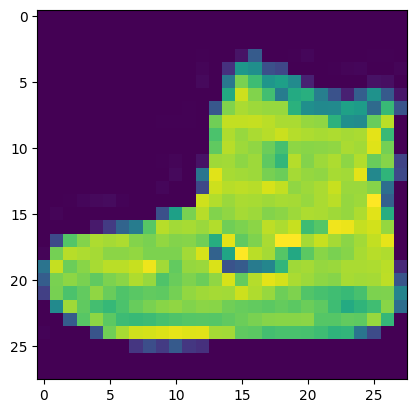

In [53]:
plt.imshow(tempx[0])

In [54]:
y_test=load_mnist_labels("/content/drive/MyDrive/data/fashion/t10k-labels-idx1-ubyte")
y_test[0]

9

In [55]:
unique_labels_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [57]:
x_color = np.zeros((tempx.shape[0], tempx.shape[1], tempx.shape[2], 3), dtype=np.uint8)
x_color[..., 0] = tempx
x_color[..., 1] = tempx
x_color[..., 2] = tempx
x= x_color

In [58]:
unique_labels=np.array(unique_labels_list)

In [59]:
unique_labels[y[0]]

'Ankle boot'

In [60]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=42)

len(x_train),len(x_val),len(y_train),len(y_val)

(48000, 12000, 48000, 12000)

In [61]:
x[100].shape

(28, 28, 3)

In [62]:
BATCH_SIZE=32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.batch(BATCH_SIZE)
        return data_batch

In [63]:
train_data=create_data_batches(x_train,y_train)
val_data=create_data_batches(x_val,y_val,valid_data=True)


Creating training data batches...
Creating validation data batches...


In [64]:
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 28, 28, 3), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None,), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 28, 28, 3), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None,), dtype=tf.uint8, name=None)))

In [65]:
import matplotlib.pyplot as plt
def show_25_image(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[labels[i]])
    plt.axis("off")

In [66]:
train_images,train_labels =next(train_data.as_numpy_iterator())
len(train_images),len(train_labels)


(32, 32)

In [67]:
train_labels

array([8, 3, 1, 7, 9, 7, 9, 4, 2, 8, 6, 4, 3, 1, 7, 3, 2, 0, 5, 9, 2, 5,
       7, 7, 4, 1, 8, 9, 2, 2, 4, 7], dtype=uint8)

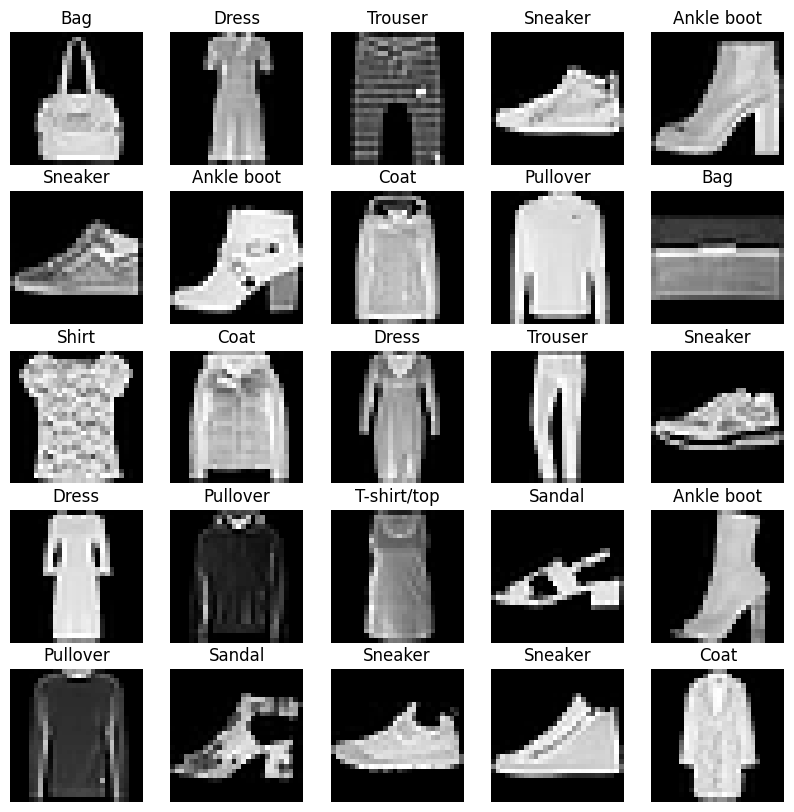

In [68]:
show_25_image(train_images,train_labels)

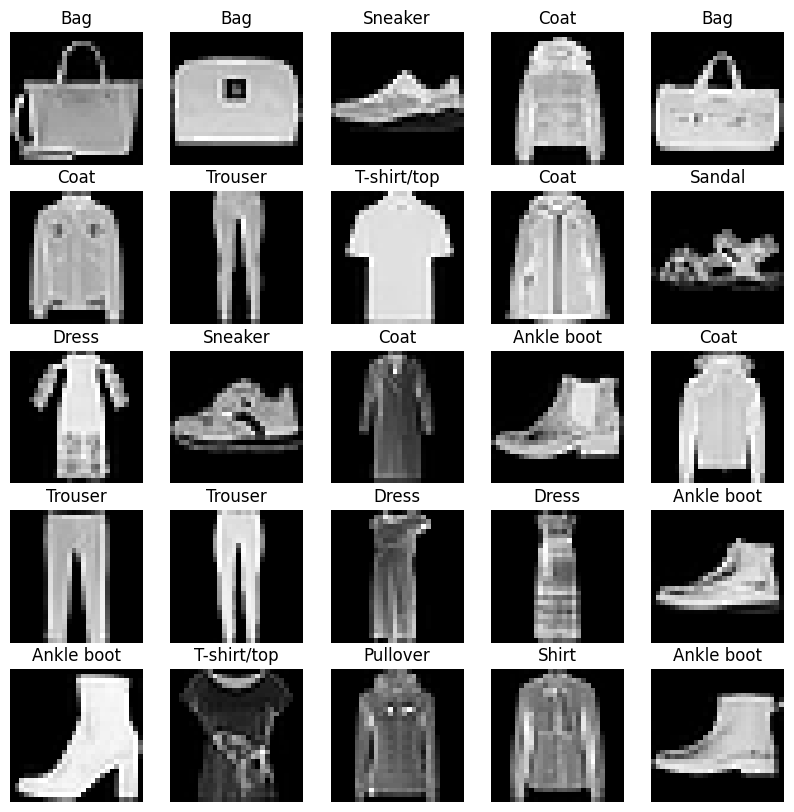

In [69]:
val_images,val_labels =next(val_data.as_numpy_iterator())
len(val_images),len(val_labels)
show_25_image(val_images,val_labels)

In [70]:
INPUT_SHAPE = [None,28,28,3]

OUTPUT_SHAPE=len(unique_labels)

MODEL_URL="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2"

In [71]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with: ",MODEL_URL)

  model=tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")
  ])
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  model.build(INPUT_SHAPE)
  return model

In [72]:
model=create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1000)              21612360  
                                                                 
 dense_3 (Dense)             (None, 10)                10010     
                                                                 
Total params: 21622370 (82.48 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 21612360 (82.44 MB)
_________________________________________________________________


## Training our model